# GECCO2019 - Bi-objective Traveling Thief Problem 

This worksheet contains the evaluation for the competition at GECCO2019. 

After having received all submissions, the evaluation will be done as follows:

For each of the nine test problems

1. We merged the solution sets of all submissions and extract the non-dominated set.
2. The minimum in time and the maximum in profit will be used to determine the reference point. With respect to this reference point the quality of each submission will be measured using the hypervolume indicator.

3. We will sort the submissions according to the achieved hypervolume in descending order and give points as follows: 1st place -> 3 points, 2nd place -> 2 points, 3rd place -> 1 point.

By adding up the points for each submission we will create the overall ranking. Please note, that depending on the number of submissions the evaluation might need to be reconsidered.

The validation has already been done using the Java code. Which means that each submission has the correct number of solutions (less than the maximum specfied at the competition homepage).


## Imports necessary for the evaluation

In [48]:
from non_dominated_sorting import fast_non_dominated_sort
import os.path
import numpy as np
import matplotlib.pyplot as plt
from hv import Hypervolume
from normalization import normalize
import pandas as pd

## Participants and Problems

In [49]:
# the result folder as a path
folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "submissions")

# all submissions received
participants = ["ALLAOUI", "jomar", "shisunzhang"]

# all the problems to be solved
problems = ["a280_n279", "a280_n1395", "a280_n2790",
            "fnl4461_n4460", "fnl4461_n22300", "fnl4461_n44600", 
            "pla33810_n33809", "pla33810_n169045", "pla33810_n338090"
]


## Loading all the data

Load all the data from the results directory and convert it to a minimization problem.
The data dictionary containts all submissions of a partipant. The set of non-dominated points
is converted to a minimization problem by multiplying the profit times -1.

In [50]:

data = {}

for problem in problems:
    _entry = {}
    for participant in participants:
        
        # check for the corresponding file
        fname = "%s_%s.f" % (participant, problem)   
        path_to_file = os.path.join(folder,participant, fname)
        
        # in case the wrong delimiter was used
        if not os.path.isfile(path_to_file):
            fname = "%s_%s.f" % (participant, problem.replace("_", "-"))
            path_to_file = os.path.join(folder,participant, fname)
         
        # load the values in the objective space - first column is time, second profit
        _F = np.loadtxt(path_to_file)
        
        # modify it to a min-min problem by multiplying the profit by -1
        _entry[participant] = _F * [1, -1]
        
    data[problem] = _entry




## Plot the results

To have an idea how the submissions look like, we were plotting the results first.

Because the ranges of submissions might vary tremendously, for some problems visually no different can be seen.
Also, note that the plots are not normalized yet and the ranges are pretty large.

a280_n279


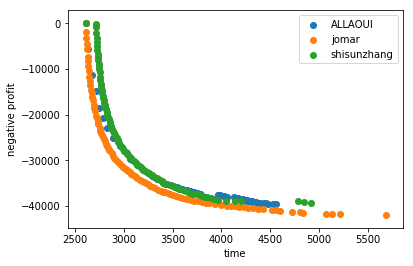

a280_n1395


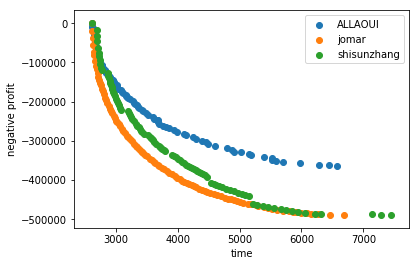

a280_n2790


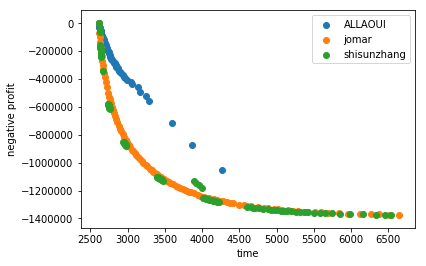

fnl4461_n4460


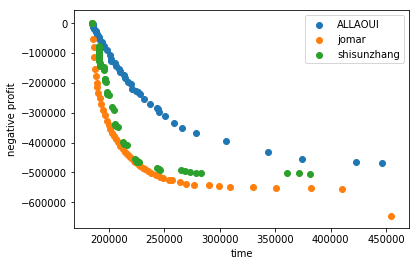

fnl4461_n22300


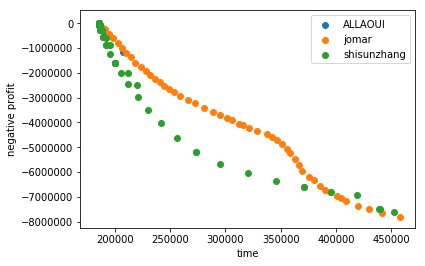

fnl4461_n44600


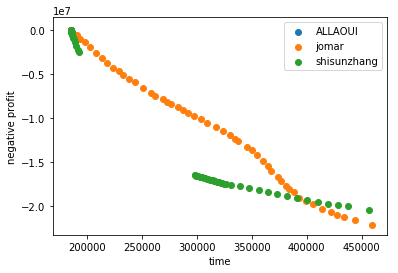

pla33810_n33809


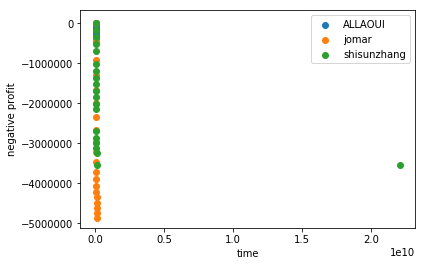

pla33810_n169045


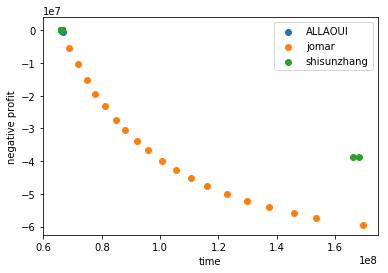

pla33810_n338090


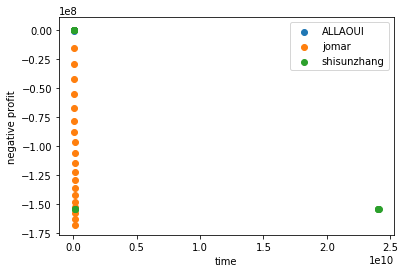

In [51]:
for problem in problems:
    
    for participant in participants:    
        _F = data[problem][participant]
        plt.scatter(_F[:,0], _F[:,1], label=participant)
        
    print("=" * 60)
    print(problem)
    print("=" * 60)
    plt.xlabel("time")
    plt.ylabel("negative profit")
    plt.legend()
    plt.show()
        

## Find the reference non-dominated set for each problem

For each problem we add the submissions to a new population and filter out the non-dominated solutions. Then, we take the minimum and the maximum of this set as the ideal and nadir point the normalize the results.

In [55]:

ideal_point = {}
nadir_point = {}
ndf = {}

for problem in problems:
    
    # the merged non-dominated solutions for the specific problem
    M = []
    for participant in participants:    
        _F = data[problem][participant]
        M.append(_F)
        
    M = np.vstack(M)    
    I = fast_non_dominated_sort(M)[0]
    M = M[I, :]
    
    ideal_point[problem] = np.min(M, axis=0)
    nadir_point[problem] = np.max(M, axis=0)
    ndf[problem] = M
    
    

In the following for each problem the non-dominated set of solutions is first normalized using the boundaries found before and then hypervolume is calculated.
If the reference point is larger than every solution submitted the hypervolume is zero.

In [56]:
results = []

for problem in problems:
    
    z = ideal_point[problem]
    z_nad = nadir_point[problem]
 
    for participant in participants:    
        _F = data[problem][participant]
        _N = normalize(_F, z, z_nad)
        _hv = Hypervolume(np.array([1,1])).calc(_N)
        results.append({'problem' : problem, 'participant' : participant, 'hv' : _hv})
        
df = pd.DataFrame(results, columns=["problem", "participant", "hv"])


In [57]:
for problem in problems:

    print("=" * 60)
    print(problem)
    print("=" * 60)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    print(_df)

a280_n279
     problem  participant        hv
1  a280_n279        jomar  0.893290
0  a280_n279      ALLAOUI  0.835566
2  a280_n279  shisunzhang  0.823563
a280_n1395
      problem  participant        hv
4  a280_n1395        jomar  0.816607
5  a280_n1395  shisunzhang  0.756445
3  a280_n1395      ALLAOUI  0.581371
a280_n2790
      problem  participant        hv
7  a280_n2790        jomar  0.872649
8  a280_n2790  shisunzhang  0.861102
6  a280_n2790      ALLAOUI  0.621785
fnl4461_n4460
          problem  participant        hv
10  fnl4461_n4460        jomar  0.794519
11  fnl4461_n4460  shisunzhang  0.719242
9   fnl4461_n4460      ALLAOUI  0.553804
fnl4461_n22300
           problem  participant        hv
14  fnl4461_n22300  shisunzhang  0.670849
13  fnl4461_n22300        jomar  0.554188
12  fnl4461_n22300      ALLAOUI  0.139420
fnl4461_n44600
           problem  participant        hv
17  fnl4461_n44600  shisunzhang  0.540072
16  fnl4461_n44600        jomar  0.534185
15  fnl4461_n44600      AL

The data frame containts now all the results. Now we need to apply the ranking.

In [58]:
# the final ranking. And add zero points initially (sum is later taken anyway...)
ranking = []
for participant in participants:
    ranking.append({'participant': participant, 'points' : 0})


# one more time loop through problem wise
for problem in problems:
    
    _df = df[df["problem"] == problem].copy()
    
    # sort descending by hv
    _df.sort_values("hv", ascending=False, inplace=True)
    
    # 3 points for the 1st place
    first = _df.iloc[0]["participant"]
    ranking.append({'participant': first, 'points' : 3})
    
    # 2 points for the 2nd place
    second = _df.iloc[1]["participant"]
    ranking.append({'participant': second, 'points' : 2})
    
    # 1 point for the 3rd place
    third = _df.iloc[2]["participant"]
    ranking.append({'participant': third, 'points' : 1})

    
ranking = pd.DataFrame(ranking, columns=["participant", "points"])

# Leaderboard

Now let us some up the points for each problem and evaluate the winner!

In [59]:
ranking.groupby('participant').sum().sort_values("points", ascending=False)

,points
participant,
jomar,25
shisunzhang,19
ALLAOUI,10


## Some additional Visualizations 

a280_n279
     problem  participant        hv
1  a280_n279        jomar  0.893290
0  a280_n279      ALLAOUI  0.835566
2  a280_n279  shisunzhang  0.823563


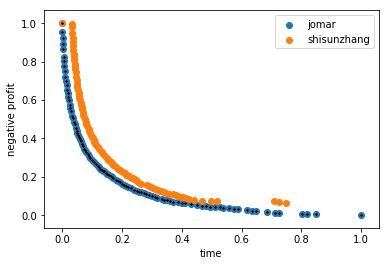

a280_n1395
      problem  participant        hv
4  a280_n1395        jomar  0.816607
5  a280_n1395  shisunzhang  0.756445
3  a280_n1395      ALLAOUI  0.581371


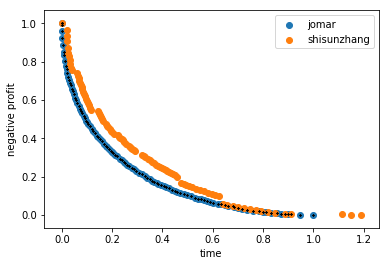

a280_n2790
      problem  participant        hv
7  a280_n2790        jomar  0.872649
8  a280_n2790  shisunzhang  0.861102
6  a280_n2790      ALLAOUI  0.621785


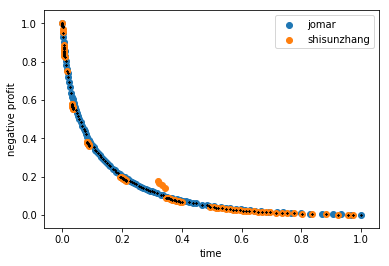

fnl4461_n4460
          problem  participant        hv
10  fnl4461_n4460        jomar  0.794519
11  fnl4461_n4460  shisunzhang  0.719242
9   fnl4461_n4460      ALLAOUI  0.553804


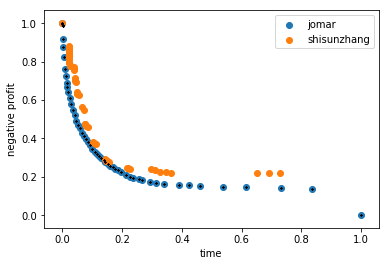

fnl4461_n22300
           problem  participant        hv
14  fnl4461_n22300  shisunzhang  0.670849
13  fnl4461_n22300        jomar  0.554188
12  fnl4461_n22300      ALLAOUI  0.139420


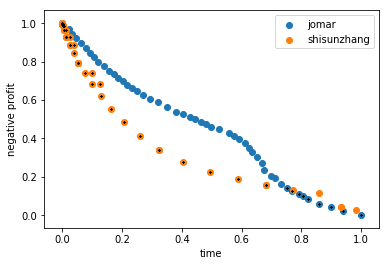

fnl4461_n44600
           problem  participant        hv
17  fnl4461_n44600  shisunzhang  0.540072
16  fnl4461_n44600        jomar  0.534185
15  fnl4461_n44600      ALLAOUI  0.009693


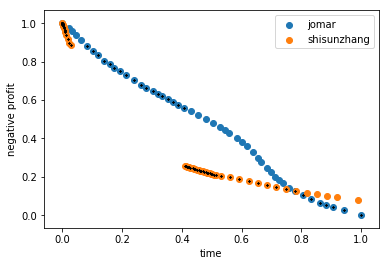

pla33810_n33809
            problem  participant        hv
19  pla33810_n33809        jomar  0.718148
20  pla33810_n33809  shisunzhang  0.496913
18  pla33810_n33809      ALLAOUI  0.090569


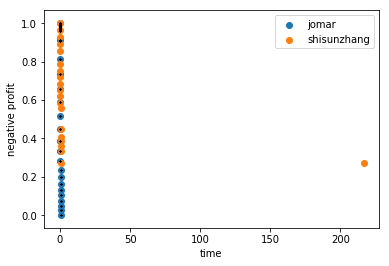

pla33810_n169045
             problem  participant        hv
22  pla33810_n169045        jomar  0.697086
23  pla33810_n169045  shisunzhang  0.022390
21  pla33810_n169045      ALLAOUI  0.007377


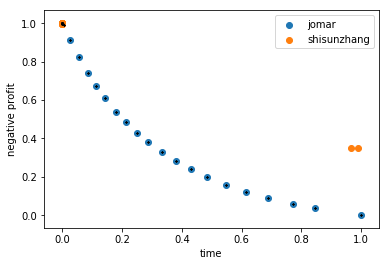

pla33810_n338090
             problem  participant        hv
25  pla33810_n338090        jomar  0.696987
26  pla33810_n338090  shisunzhang  0.049182
24  pla33810_n338090      ALLAOUI  0.001853


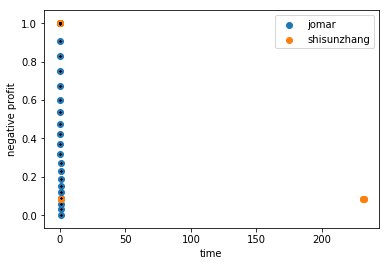

In [60]:

do_normalize = True

for problem in problems:
    
    for participant in ["jomar", "shisunzhang"]:    
        _F = data[problem][participant]
        if do_normalize:
            _F = normalize(_F, ideal_point[problem], nadir_point[problem])
            
        plt.scatter(_F[:,0], _F[:,1], label=participant)
        
    _ndf = ndf[problem]
    if do_normalize:
        _ndf = normalize(_ndf, ideal_point[problem], nadir_point[problem])
    
    plt.scatter(_ndf[:,0], _ndf[:,1], marker='x', s=2, color='black')
        
    print("=" * 60)
    print(problem)
    print("=" * 60)
    
    _df = df[df["problem"] == problem].copy()
    _df.sort_values("hv", ascending=False, inplace=True)
    _df.reset_index(drop=True)
    print(_df)

    plt.xlabel("time")
    plt.ylabel("negative profit")
    plt.legend()
    plt.show()
        